In [1]:
import janus
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks,argrelmin
import imp
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

imp.reload(janus)

<module 'janus' from '/Users/zack/Documents/oscillators/snakingoscillators/janus.py'>

### A limit-cycle chimera state

runtime: 43.752950


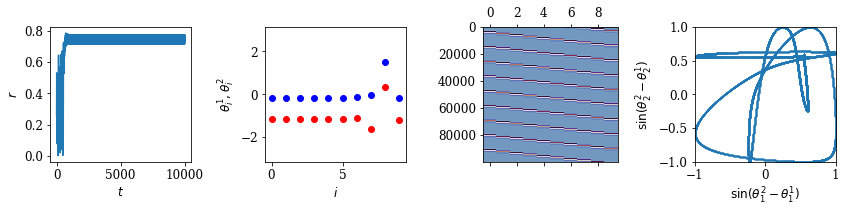

In [2]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=1
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

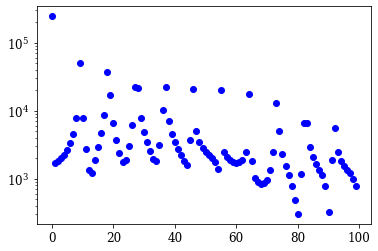

In [91]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

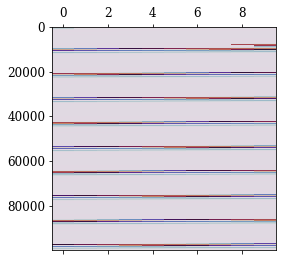

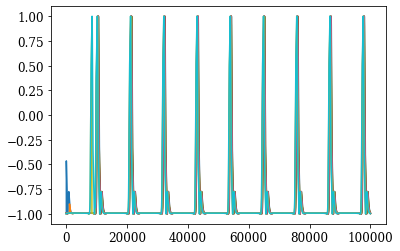

In [107]:
nu=10.5/dt
plt.matshow(np.transpose([np.cos(np.roll(phi0[:,i], 100+int(nu*i))) for i in range(N)]),aspect=len(phi0[0])/len(phi0),cmap='twilight')
plt.show()
plt.plot(np.transpose([np.cos(np.roll(phi0[:,i], 100+int(nu*i))) for i in range(N)]))
plt.show()

### A chaotic or invariant torus chimera state

runtime: 31.561605


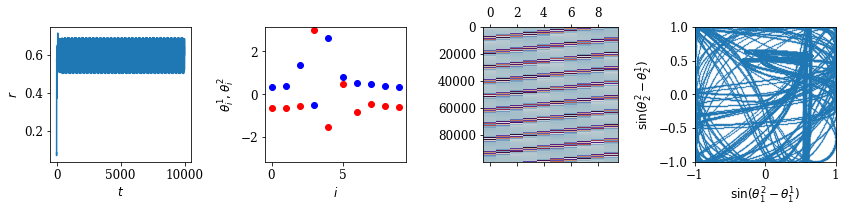

In [196]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=9
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

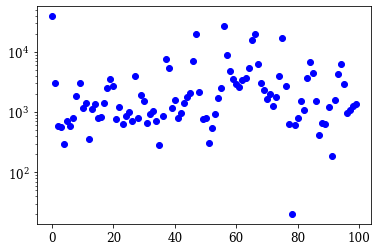

In [111]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

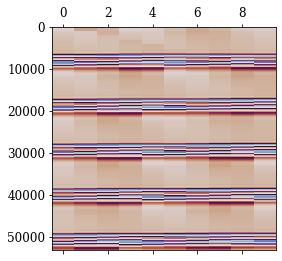

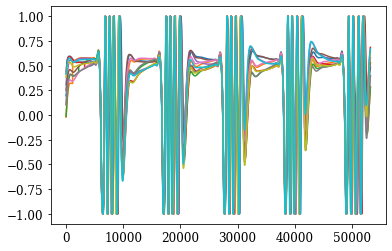

In [192]:
nmax=5*(int(len(phases)/10)+650)

phi0=np.arctan2(phases[:nmax,N:2*N],phases[:nmax,:N])
phi1=np.arctan2(phases[:nmax,3*N:],phases[:nmax,2*N:3*N])

nu=10.5/dt
plt.matshow(np.transpose([np.cos(np.roll(phi1[:,i], 100+int(nu*i))) for i in range(N)]),aspect=len(phi0[0])/len(phi0),cmap='twilight')
plt.show()
plt.plot(np.transpose([np.cos(np.roll(phi1[:,i], 100+int(nu*i))-phi0[:,0]) for i in range(N)]))
plt.show()

### Continue a limit cycle chimera

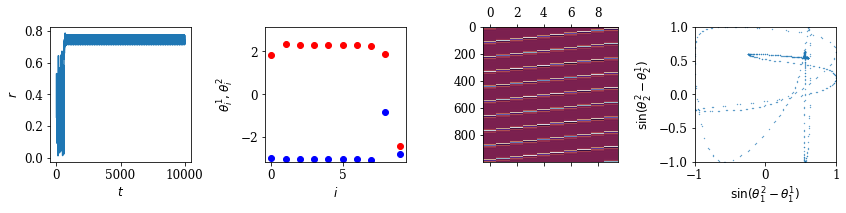

(array([ 6, 13, 20, 27, 34, 41, 48, 55, 62]),)

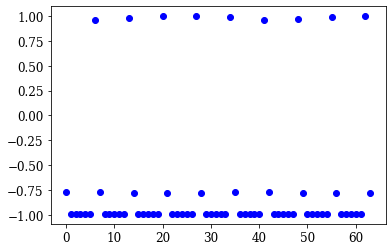

In [4]:
filebase='data/chimera/'
times=np.load(filebase+'times.npy')
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')
N=int((len(fs)+2)/4)
sigma0=0.35
omega=1
beta=0.25
gamma=0.1
phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

minds=find_peaks(phases[:,0])[0]
plt.plot(phases[minds,0],'bo')
np.where(phases[minds,0]>0.9)

In [ ]:
m0=6
m1=13
p0=times[minds[m1]]-times[minds[m0]]
x0=(times[minds[m0]:minds[m1]]-times[minds[m0]])/p0
y0=phases[minds[m0]:minds[m1]].T
sigma=sigma0
dsigma=0.5e-3
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.347
sigmamax=0.353
start=timeit.default_timer()
sigmas,sols=janus.cont(omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols[-1].x, np.transpose([np.roll(theta[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols[-1].x, np.transpose([np.roll(phi[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

The algorithm converged to the desired accuracy.
0.350000	-5.000e-04	219	109.700171	2	38.968907	
0.349500	-5.000e-04	219	109.258778	1	19.627745	
0.349000	-5.000e-04	219	108.768205	1	16.109468	
0.348500	-5.000e-04	219	108.311546	1	19.616614	
0.348000	-5.000e-04	219	107.860657	1	21.059255	
0.347500	-5.000e-04	219	107.415460	1	19.333337	
0.347000	-5.000e-04	219	106.975683	1	19.798770	
runtime:  154.53196785999899


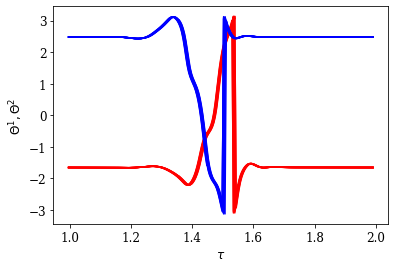

In [173]:
dsigma=-0.5e-3
start=timeit.default_timer()
sigmas2,sols2=janus.cont(omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols2[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols2[-1].x, np.transpose([np.roll(theta[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols2[-1].x, np.transpose([np.roll(phi[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

In [174]:
Sigmas=[sigmas2[-i] for i in range(1,len(sols2))]+[sigmas[i] for i in range(len(sols))]
Periods=[sols2[-i].p[0] for i in range(1,len(sols2))]+[sols[i].p[0] for i in range(len(sols))]
Ts=[sols2[-i].x for i in range(1,len(sols2))]+[sols[i].x for i in range(len(sols))]
Ys=[sols2[-i].y for i in range(1,len(sols2))]+[sols[i].y for i in range(len(sols))]
np.save(filebase+'lcsigmas.npy',Sigmas)
np.save(filebase+'lcperiods.npy',Periods)
for i in range(len(Sigmas)):
    np.save(filebase+'lctimes_'+str(i)+'.npy',Ts[i])
    np.save(filebase+'lcphases_'+str(i)+'.npy',Ys[i])

### Continue the unstable limit cycle chimera branch

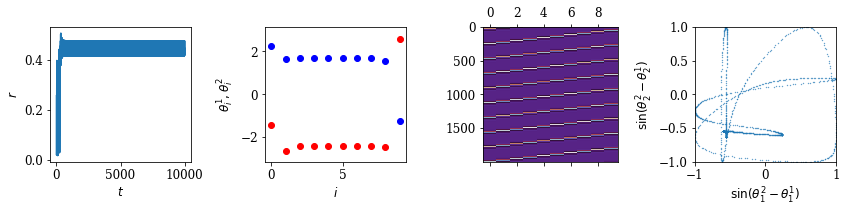

(array([ 0,  7, 14, 21, 28, 35, 42, 49, 56, 63]),)

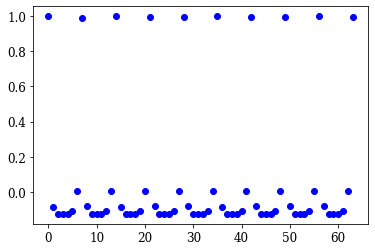

In [134]:
filebase='data/uchimera/'
times=np.load(filebase+'times.npy')
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')
N=int((len(fs)+2)/4)
sigma0=0.35
omega=1
beta=0.25
gamma=0.1
phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

minds=find_peaks(phases[:,0])[0]
plt.plot(phases[minds,0],'bo')
np.where(phases[minds,0]>0.9)

The algorithm converged to the desired accuracy.
0.350000	5.000e-04	219	109.700171	2	38.143640	
0.350500	5.000e-04	219	110.174768	1	14.224763	
0.351000	5.000e-04	219	110.658256	1	19.754662	
0.351500	5.000e-04	219	111.146225	1	4.830690	
0.352000	5.000e-04	219	111.643791	1	4.943140	
0.352500	5.000e-04	219	112.149813	1	18.212603	
0.353000	5.000e-04	219	112.662350	1	18.666599	
runtime:  118.79389978799736


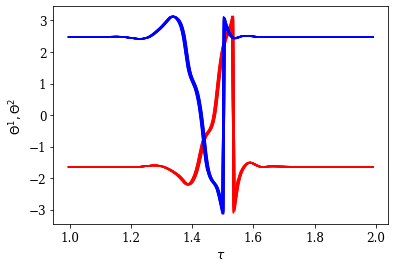

In [171]:
m0=7
m1=14
phases=np.concatenate([np.cos(-np.flip(phi0,axis=0)),np.sin(-np.flip(phi0,axis=0)),np.cos(-np.flip(phi1,axis=0)),np.sin(-np.flip(phi1,axis=0))],axis=1)
p0=times[minds[m1]]-times[minds[m0]]
x0=(times[minds[m0]:minds[m1]]-times[minds[m0]])/p0
y0=phases[minds[m0]:minds[m1]].T
sigma=sigma0
dsigma=0.5e-3
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.347
sigmamax=0.353
start=timeit.default_timer()
sigmas,sols=janus.cont(omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols[-1].x, np.transpose([np.roll(theta[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols[-1].x, np.transpose([np.roll(phi[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

The algorithm converged to the desired accuracy.
0.350000	-5.000e-04	219	109.700171	2	38.968907	
0.349500	-5.000e-04	219	109.258778	1	19.627745	
0.349000	-5.000e-04	219	108.768205	1	16.109468	
0.348500	-5.000e-04	219	108.311546	1	19.616614	
0.348000	-5.000e-04	219	107.860657	1	21.059255	
0.347500	-5.000e-04	219	107.415460	1	19.333337	
0.347000	-5.000e-04	219	106.975683	1	19.798770	
runtime:  154.53196785999899


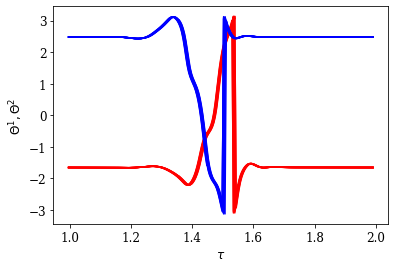

In [173]:
dsigma=-0.5e-3
start=timeit.default_timer()
sigmas2,sols2=janus.cont(omega,beta,gamma,sigma,x0,y0,p0,sigmamin,sigmamax,dsigma,maxnodes=2000)
stop=timeit.default_timer()
print("runtime: ",stop-start)
phases=sols2[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Theta^1, \Theta^2$')
plt.plot(sols2[-1].x, np.transpose([np.roll(theta[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='red')
plt.plot(sols2[-1].x, np.transpose([np.roll(phi[:,i], 100-int(len(theta)/N*i)) for i in range(N)]),color='blue')
plt.show()

In [174]:
Sigmas=[sigmas2[-i] for i in range(1,len(sols2))]+[sigmas[i] for i in range(len(sols))]
Periods=[sols2[-i].p[0] for i in range(1,len(sols2))]+[sols[i].p[0] for i in range(len(sols))]
Ts=[sols2[-i].x for i in range(1,len(sols2))]+[sols[i].x for i in range(len(sols))]
Ys=[sols2[-i].y for i in range(1,len(sols2))]+[sols[i].y for i in range(len(sols))]
np.save(filebase+'lcsigmas.npy',Sigmas)
np.save(filebase+'lcperiods.npy',Periods)
for i in range(len(Sigmas)):
    np.save(filebase+'lctimes_'+str(i)+'.npy',Ts[i])
    np.save(filebase+'lcphases_'+str(i)+'.npy',Ys[i])

### Plot order parameter

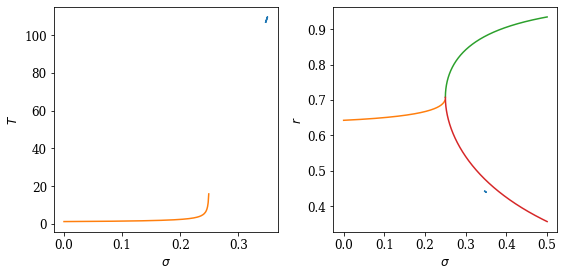

In [176]:
filebase='data/uchimera/'
Sigmas=np.load(filebase+'lcsigmas.npy')
Periods=np.load(filebase+'lcperiods.npy')
Ts=[]
Ys=[]
for i in range(len(Sigmas)):
    Ts.append(np.load(filebase+'lctimes_'+str(i)+'.npy'))
    Ys.append(np.load(filebase+'lcphases_'+str(i)+'.npy'))
Orders=[]
for i in range(len(Ys)):
    phases=Ys[i].T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    Orders.append(np.sum(r[:-1]*np.diff(Ts[i])))
    
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.xlabel('$\sigma$')
plt.ylabel('$T$')
plt.plot(Sigmas,Periods)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[1/(0.75-2*sigma-4*sigma**2)**0.5 for sigma in sigmas])

plt.subplot(1,2,2)
plt.xlabel('$\sigma$')
plt.ylabel('$r$')
plt.plot(Sigmas,Orders)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[np.mean(1/(1+0.25*(1+4*sigma-((1-4*sigma)*(3+4*sigma))**0.5*np.tan(2*np.pi/(0.75-2*sigma-4*sigma**2)**0.5*np.arange(0,100)/100*0.25*((1-4*sigma)*(3+4*sigma))**0.5))**2)**0.5) for sigma in sigmas])
sigmas=np.arange(0.25,0.5,0.00001)
plt.plot(sigmas,[(2+2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.plot(sigmas,[(2-2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.tight_layout()
plt.show()

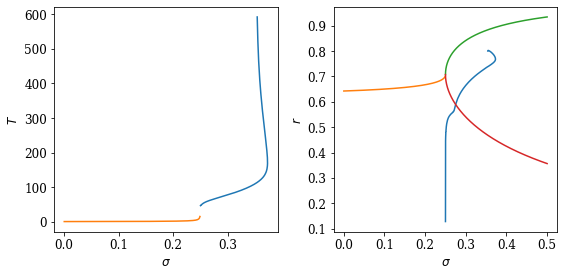

In [192]:
Orders=[]
for i in range(len(Ys)):
    phases=Ys[i].T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    Orders.append(np.sum(r[:-1]*np.diff(Ts[i])))
    
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.xlabel('$\sigma$')
plt.ylabel('$T$')
plt.plot(Sigmas,Periods)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[1/(0.75-2*sigma-4*sigma**2)**0.5 for sigma in sigmas])

plt.subplot(1,2,2)
plt.xlabel('$\sigma$')
plt.ylabel('$r$')
plt.plot(Sigmas,Orders)
sigmas=np.arange(0,0.25,0.001)
plt.plot(sigmas,[np.mean(1/(1+0.25*(1+4*sigma-((1-4*sigma)*(3+4*sigma))**0.5*np.tan(2*np.pi/(0.75-2*sigma-4*sigma**2)**0.5*np.arange(0,100)/100*0.25*((1-4*sigma)*(3+4*sigma))**0.5))**2)**0.5) for sigma in sigmas])
sigmas=np.arange(0.25,0.5,0.00001)
plt.plot(sigmas,[(2+2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.plot(sigmas,[(2-2*(1-1/(4*(0.25+sigma)**2))**0.5)**0.5/2 for sigma in sigmas])
plt.tight_layout()
plt.savefig('diagram.pdf')
plt.show()